# Exercise 1: Data and RDM handling

In [1]:
import numpy as np
from scipy import io
import pyrsa

## Load model RDMs
Here the models are different layers of Alexnet.
For each layer, different models of how the fMRI voxels sample the neurons are being considered.

The simulated data are from a Matlab program (Kriegeskorte & Diedrichsen 2016), so we load the Matlab files in .mat format. 

In [2]:
matlab_data = io.matlab.loadmat('rdms_inferring/modelRDMs.mat')
matlab_data = matlab_data['modelRDMs']
n_models = len(matlab_data[0])
model_names = [matlab_data[0][i][0][0] for i in range(n_models)]
measurement_model = [matlab_data[0][i][1][0] for i in range(n_models)]
rdms_array = np.array([matlab_data[0][i][2][0] for i in range(n_models)])

These steps are not specific to the toolbox, but to the format the RDMs were originally saved in.
To load other data, simply transform them such that they are numpy arrays of either the whole RDM or vector format of the upper triangular part of the matrix.

## Store the model RDMs as a pyRSA object
We place the RDMs in a pyRSA object which can contain additional descriptors for the RDMs and the experimental conditions.
Here we label each RDM with the name of the brain-computational model (AlexNet layer) and the name of the measurement model.

In [3]:
model_rdms = pyrsa.rdm.RDMs(rdms_array,
                            rdm_descriptors={'brain_computational_model':model_names,
                                             'measurement_model':measurement_model}
                           )

model_rdms is now a custom object, which contains all the rdms from the .mat file with the additional information.
It also has a few functions for forming subsets of the data, saving and loading, etc.

## Show the RDMs from AlexNet layer conv1

As a simple example select the rdms, which correspond to the first convolutional layer. These can then be plotted using the function pyrsa.vis.show_rdm.

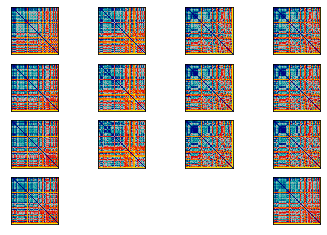

In [4]:
conv1_rdms = model_rdms.subset('brain_computational_model','conv1')
pyrsa.vis.show_rdm(conv1_rdms, do_rank_transform=True)

## Print info about a set of RDMs
The pyRSA objects can simply be passed to the print function to obtain a short description of their content.

In [5]:
print(conv1_rdms)

pyrsa.rdm.RDMs
13 RDM(s) over 92 conditions

dissimilarity_measure = 
None

dissimilarities[0] = 
[[0.00000000e+00 7.35978432e+08 5.35502528e+08 ... 1.34278669e+09
  1.34848320e+09 4.47360614e+09]
 [7.35978432e+08 0.00000000e+00 6.72164736e+08 ... 1.52816154e+09
  1.59405773e+09 4.56825293e+09]
 [5.35502528e+08 6.72164736e+08 0.00000000e+00 ... 1.40547021e+09
  1.39483494e+09 4.35671757e+09]
 ...
 [1.34278669e+09 1.52816154e+09 1.40547021e+09 ... 0.00000000e+00
  1.85234202e+09 4.90678682e+09]
 [1.34848320e+09 1.59405773e+09 1.39483494e+09 ... 1.85234202e+09
  0.00000000e+00 5.00813875e+09]
 [4.47360614e+09 4.56825293e+09 4.35671757e+09 ... 4.90678682e+09
  5.00813875e+09 0.00000000e+00]]

descriptors: 

rdm_descriptors: 
brain_computational_model = ['conv1' 'conv1' 'conv1' 'conv1' 'conv1' 'conv1' 'conv1' 'conv1' 'conv1'
 'conv1' 'conv1' 'conv1' 'conv1']
measurement_model = ['complete' 'smooth1sepFeat' 'smooth1avgFeat' 'smooth1rpwavgFeat'
 'smooth1rpwavgFeatR500' 'smooth2sepFeat' 'smoo

Of course, you can also show all RDMs or select any other subset. Have a look at the different RDMs.

How many RDMs are there for each layer? How different do the different measurement models look to you and how different do the differen layers look?

# Exercise 2: Fixed model inference
## Load data RDMs
Here we use simulated data to demonstrate RSA inference.
Since we know the true data-generating model in each case, we can tell when inference fails or succeeds.

In [6]:
matlab_data = io.matlab.loadmat('rdms_inferring/noisyModelRDMs_demo.mat')
repr_names_matlab = matlab_data['reprNames']
fwhms_matlab = matlab_data['FWHMs']
noise_std_matlab = matlab_data['relNoiseStds']
rdms_matlab = matlab_data['noisyModelRDMs']
repr_names = [repr_names_matlab[i][0][0] for i in range(repr_names_matlab.shape[0])]
fwhms = fwhms_matlab.squeeze().astype('float')
noise_std = noise_std_matlab.squeeze().astype('float')
rdms_matrix = rdms_matlab.squeeze().astype('float')


## Choose one of the data RDMs for inference

The chosen ground truth model is:
conv3
with noise level:
3.0
with averaging width (full width at half magnitude):
0.0


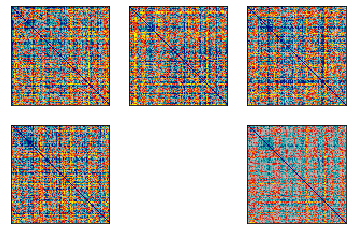

In [7]:
# indices choosing brain-computational model, noise level, and the size of the kernel with which each voxel samples the neural activity
i_rep = 2 #np.random.randint(len(repr_names)) 
i_noise = 1 #np.random.randint(len(noise_std))
i_fwhm = 0 #np.random.randint(len(fwhms))

# print the chosen representation definition
repr_name = repr_names[i_rep]
print('The chosen ground truth model is:')
print(repr_name)
print('with noise level:')
print(noise_std[i_noise])
print('with averaging width (full width at half magnitude):')
print(fwhms[i_fwhm])

# put the rdms into an RDMs object and show it
rdms_data = pyrsa.rdm.RDMs(rdms_matrix[:, i_rep, i_fwhm, i_noise, :].transpose())
pyrsa.vis.show_rdm(rdms_data, do_rank_transform=True)


## Define fixed models
An "RDM model" is a pyRSA object that can predict a data RDM.
For example, an RDM model may contain a set of predictor RDMs, which predict the data RDM as a weighted combination.
Here we use fixed RDM models, which contain just a single RDM with no parameters to be fitted.

In [ ]:
models = []
for i_model in np.unique(model_names):
    models.append(pyrsa.model.ModelFixed(i_model,
        model_rdms.subset('brain_computational_model', i_model).subset('measurement_model','complete')))

print('created the following models:')
for i in range(len(models)):
    print(models[i].name)

## RSA 1.0: Just compare model RDMs to measured RDMs
evaluate models naively, i.e. simply compute the average correlation to the data

In [ ]:
results_1 = pyrsa.inference.eval_fixed(models, rdms_data, method='corr')
pyrsa.vis.plot_model_comparison(results_1)

results_1 = pyrsa.inference.eval_fixed(models, rdms_data, method='spearman')
pyrsa.vis.plot_model_comparison(results_1)

results_1 = pyrsa.inference.eval_fixed(models, rdms_data, method='tau-a')
pyrsa.vis.plot_model_comparison(results_1)

In these plots the models do not have errorbars as we did not run any bootstrapping. The upper noise ceiling is computed by evaluating the average of all rdms, which is a true upper limit on performance. The lower noise ceiling is a leave one out crossvalidation of the average, i.e. all but one rdm are averaged and evaluated on the left out rdm.

## Model comparison by bootstrapping the subjects
We can bootstrap resample the subjects to obtain 95% confidence intervals and to perform model-comparative inference.


In [ ]:
results_2a = pyrsa.inference.eval_bootstrap_rdm(models, rdms_data, method='corr', boot_noise_ceil=True)
pyrsa.vis.plot_model_comparison(results_2a)

## Model comparison by bootstrapping the stimuli
We can alternatively bootstrap resample the stimuli to obtain 95% confidence intervals and to perform model-comparative inference.


In [ ]:
# b) using only bootstrapping over patterns
results_2b = pyrsa.inference.eval_bootstrap_pattern(models, rdms_data, method='corr')
pyrsa.vis.plot_model_comparison(results_2b)

## Model comparison by bootstrapping both stimuli and subjects
Finally, we can bootstrap resample both stimuli and subjects:

In [ ]:
# c) bootstrap over both patterns and subjects
results_2c = pyrsa.inference.eval_bootstrap(models, rdms_data, method='corr')
pyrsa.vis.plot_model_comparison(results_2c)

## Questions
Does the right model win? And do the mean estimates from bootstrapping differ from the evaluations over the whole dataset?

_Generally the average over bootstrap samples is similar to the evaluation over all data._

Compare the results for the different bootstrapping methods. Which method leads to the widest confidence intervals, which one to the smallest?

_Generally bootstrapping over subjects leads to the smallest confidence intervals and bootstrapping over both dimensions leads to the widest confidence intervals. This is caused by the different generalizations we try to achieve. Bootstrapping over subjects corresponds to our expectation how variable the results would be if we had sampled different subjects with the same images. Bootstrapping over stimuli corresponds to the question how variable our results would be if we had sampled different stimuli in the same subjects. Finally, Bootstrapping over both corresponds to an estimate how variable the results would be if we had sampled new subjects with new stimuli._

Make two additional observations here:

1. The true model is not necessarily winning as the different measurement models yield substantially different RDMs
2. Often none of the models reaches the noise ceiling

Thus, to make this a sensible analysis one should take the measurement model into account! (See Kriegeskorte & Diedrichsen 2016)

# Exercise 3: Crossvalidation for flexible models
## defining flexible models
Here we use selection models, i.e. each model layer gets a list of rdms and only specifies that one of those is the right one

In [8]:
models_flex = []
for i_model in np.unique(model_names):
    models_flex.append(pyrsa.model.ModelSelect(i_model,
        model_rdms.subset('brain_computational_model', i_model)))

print('created the following models:')
for i in range(len(models_flex)):
    print(models_flex[i].name)

created the following models:
conv1
conv2
conv3
conv4
conv5
fc6
fc7
fc8
norm1
norm2
pool1
pool2
prob


## Crossvalidation
As we are now using flexible models, we have to do crossvalidation to get an estimate how well the model would do on new unseen data.

As a first step we create the training test and ceil sets. The last one corresponds to the traiing data for the testset which is necessary for calculating a noise ceiling. 

In [9]:
train_set, test_set, ceil_set = pyrsa.inference.sets_k_fold(rdms_data, k_pattern=3, k_rdm=2, random=False)


With these sets we can now evaluate our models as we did without crossvalidaton and plot the results. With a single training/testset combination we do not get errorbars.

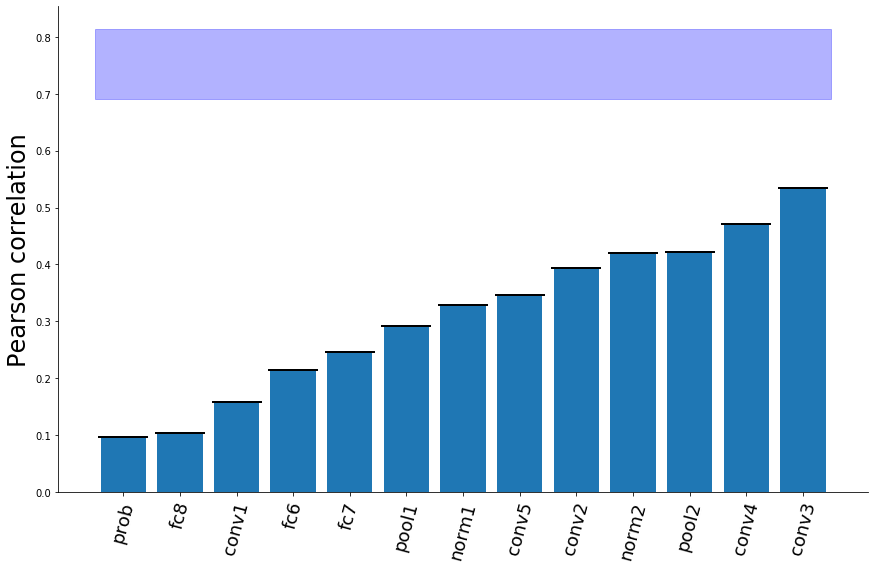

In [10]:
results_3_cv = pyrsa.inference.crossval(models_flex, rdms_data, train_set, test_set,
                                        ceil_set=ceil_set, method='corr')
# plot results
pyrsa.vis.plot_model_comparison(results_3_cv)

## Bootstrapped Crossvalidation

Finally, we can perform bootstrapping around the crossvalidation to get uncertainty estimates for the evaluation:

100%|██████████| 1000/1000 [03:28<00:00,  4.79it/s]
/Users/heiko/Google Drive/pyrsa/pyrsa/vis/model_plot.py:35: RuntimeWarning: Mean of empty slice
  evaluations = np.nanmean(evaluations, axis=-1)


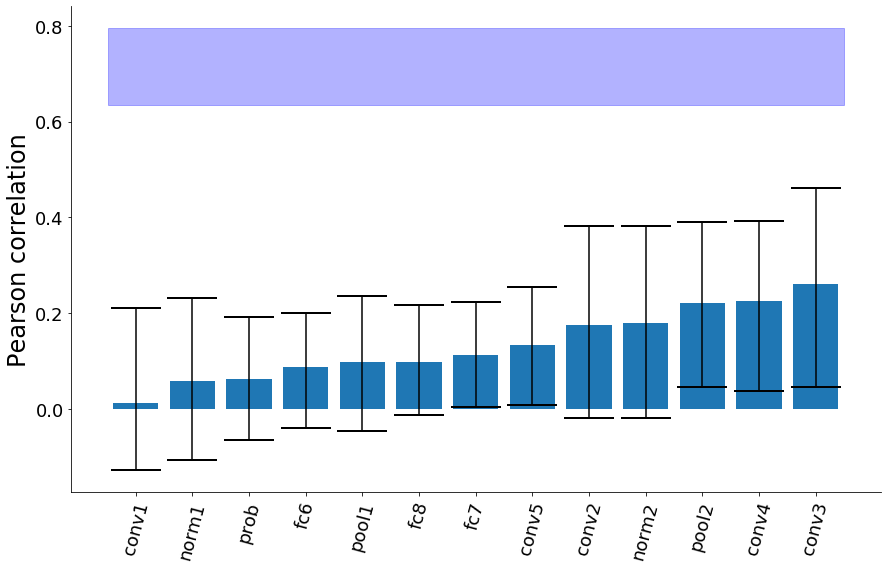

In [12]:
results_3_full = pyrsa.inference.bootstrap_crossval(models_flex, rdms_data, k_pattern=2, k_rdm=2, method='corr')
# plot results
pyrsa.vis.plot_model_comparison(results_3_full)

## Questions

Does the right model win?

_In this case the correct model usually wins, as the measurement models now contain the correct model_

Try some different settings for the bootstrap: How do the results change when you make the training and testsets larger or smaller?

_Usually the performance should become better, but more variable for smaller testsets, i.e. larger k-pattern. k-rdm should not affect the average performance much._

In [ ]:
results_3_full.evaluations[0][0]